In [ ]:
# Instalação das dependências necessárias
!pip install "tensorflow[and-cuda]" tensorflow-hub
!pip install -q tensorflow tensorflow_hub
!pip install -q scikit-learn pandas numpy tqdm

# Para usar o BGE-M3
!pip install sentence-transformers

In [ ]:
# Verificação da instalação do TensorFlow com suporte a GPU
import tensorflow as tf, pprint
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))
pprint.pprint(tf.sysconfig.get_build_info())  # mostra cuda_version e cudnn_version

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#Para usar o BGE-M3
from sentence_transformers import SentenceTransformer 

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import class_weight

2025-09-07 20:43:43.227622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ricardo/Mestrado/TAIA/NLP-Embedding/.venv/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
/home/ricardo/Mestrado/TAIA/NLP-Embedding/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Carregando os dados
df = pd.read_csv('eventos_artigos_filtrados.csv');

In [ ]:
# Explorar os dados
print("Informações do dataset:")
print(df.info())

print("\nValores ausentes por coluna:")
print(df.isnull().sum())

print("\nNúmero de linhas duplicadas:")
print(df.duplicated().sum())

print("\nTotal dos dados:")
print(df.shape[0])

print("\nBalanceamento de Classes:")
print(df['antes_2023'].value_counts())

In [3]:
# Preparação dos dados
df = df.drop(columns=['evento_nome', 'resumo'])
df = df.dropna(subset=['titulo_artigo', 'ano_edicao'])
df = df.drop_duplicates(subset=['titulo_artigo', 'ano_edicao'], keep='first')

df['antes_2023'] = df['ano_edicao'].apply(lambda x: 1 if x < 2023 else 0)

df["titulo_artigo"] = df["titulo_artigo"].astype(str).str.strip()
df["antes_2023"] = df["antes_2023"].astype(int).values

#df.head()

# Teste com BGE-M3

In [ ]:
titulos = df['titulo_artigo'].tolist()
labels = df['antes_2023'].values

# Carregamento do Modelo BGE-M3
model = SentenceTransformer("BAAI/bge-m3")
print("BGE-M3 carregado com sucesso.")

# Execução da Geração de Embeddings
embeddings_gerados = model.encode(
    titulos,
    batch_size=64,
    show_progress_bar=True
)

print(f"\nEmbeddings gerados com sucesso! Shape final: {embeddings_gerados.shape}")

# Salvamento dos Resultados
np.save('embeddings_titulos.npy', embeddings_gerados)
np.save('labels.npy', labels)

BGE-M3 carregado com sucesso.


Batches: 100%|██████████| 394/394 [00:39<00:00,  9.91it/s]



Embeddings gerados com sucesso! Shape final: (12607, 1024)


# CLASSIFICADOR 

In [8]:
# Carregamento dos Dados Pré-processados
X = np.load('embeddings_titulos.npy')
y = np.load('labels.npy')

# Divisão dos Dados em Treino e Teste
print(f"Dados carregados. Shape de X: {X.shape}, Shape de y: {y.shape} \n")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.\n")

# Verificou-se na exploração dos dados que o dataset está desbalanceado. Será aplidada a técnica de Ponderação de Classes (Class Weighting) 

# Calcula os pesos para balancear as classes com base na frequência de cada classe em y_train
#weights = class_weight.compute_class_weight(
#    class_weight='balanced',
#    classes=np.unique(y_train),
#    y=y_train
#)
# Converte o array de pesos em um dicionário que o Keras entende
#class_weights = dict(enumerate(weights))

# Setando o class_weight manualmente
class_weights = {0: 1.6, 1: 1.0} 

print(f"Pesos de Classe Calculados: {class_weights} \n")

Dados carregados. Shape de X: (12607, 1024), Shape de y: (12607,) 

Dados divididos: 10085 para treino, 2522 para teste.

Pesos de Classe Calculados: {0: 1.6, 1: 1.0} 



In [ ]:
# Construção do Modelo de Classificação
model = tf.keras.Sequential([
    # A camada de entrada espera vetores com 1024 dimensões (o tamanho do embedding ELMo)
    tf.keras.layers.InputLayer(input_shape=(1024,)),
    
    # Camada oculta para aprender padrões nos embeddings
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Dropout para evitar overfitting
    
    # Camada de saída para classificação binária
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilação do Modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Treinamento do Modelo
print("\nIniciando o treinamento do classificador...")
history = model.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=4,
    validation_data=(X_test, y_test),
    class_weight=class_weights, #Atribui os pesos de classe
    verbose=1
)

/home/ricardo/Mestrado/TAIA/NLP-Embedding/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,329 (513.00 KB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento do classificador...
Epoch 1/60
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7163 - loss: 0.7134 - val_accuracy: 0.7292 - val_loss: 0.5225
Epoch 2/60
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7256 - loss: 0.6789 - val_accuracy: 0.7228 - val_loss: 0.5242
Epoch 3/60
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7370 - loss: 0.6629 - val_accuracy: 0.7328 - val_loss: 0.5105
Epoch 4/60
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 3s 987us/step - accuracy: 0.7419 - loss: 0.6455 - val_accuracy: 0.6927 - val_loss: 0.5610
Epoch 5/60
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7486 - loss: 0.6342 - val_accuracy: 0.7054 - val_loss: 0.5405
Epoch 6/60
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7605 - loss: 0.6190 - val_accuracy: 0.7343 - val_loss: 0.5153
Epoch 7/60
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 3s 995us/step - accuracy: 0.7706 - loss: 0.6019 - val_accuracy: 0.7339 - val_loss: 0.5160
Epoch 8/60
2522/2522 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
model.save('meu_classificador_com_BGE-M3.keras')

Acurácia (Keras): 73.28%
Loss (Keras): 1.0639

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Relatório de Classificação:
                     precision    recall  f1-score   support

   Classe 0 (2023+)       0.52      0.42      0.46       694
Classe 1 (Pré-2023)       0.79      0.85      0.82      1828

           accuracy                           0.73      2522
          macro avg       0.66      0.63      0.64      2522
       weighted avg       0.72      0.73      0.72      2522

Matriz de Confusão:
[[ 289  405]
 [ 269 1559]]


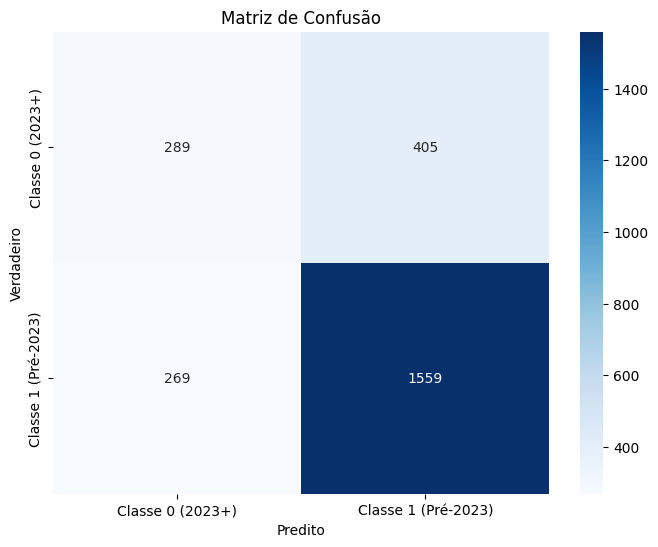

In [10]:
# Avaliação

# Avaliação básica com Keras
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia (Keras): {accuracy * 100:.2f}%")
print(f"Loss (Keras): {loss:.4f}\n")

# 2. Predições do modelo para o conjunto de teste (Probabilidades)
y_pred_prob = model.predict(X_test)

# 3. Converção em classes (0 ou 1). Se a prob > 0.5, então 1, senão 0.
y_pred = (y_pred_prob > 0.5).astype("int32")

# 4. Classificação Detalhada
print("Relatório de Classificação:")
# 0: 2023 ou DEPOIS
# 1: ANTES de 2023
target_names = ['Classe 0 (2023+)', 'Classe 1 (Pré-2023)']
print(classification_report(y_test, y_pred, target_names=target_names))

# 5. Matriz de Confusão
print("Matriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# TESTE COM DADOS DIFERENTES DO DATASET A PARIR DE UM MODELO GERADO.

In [ ]:
# 1. Carregar o Modelo de Embedding (BGE-M3)
embedding_model = SentenceTransformer("BAAI/bge-m3")

# 2. Carregar o seu Classificador Keras treinado
classificador = tf.keras.models.load_model('meu_classificador_com_BGE-M3.keras')

novos_titulos = [
    "Um estudo sobre o impacto da IA generativa no desenvolvimento de software",
    "Implementação de algoritmos de parsing para compiladores em Pascal",
    "Otimização de redes neurais para sistemas embarcados de baixa potência",
    "Análise de sistemas de informação com metodologia estruturada",
    "Fine-tuning de LLMs para tarefas de tradução em português",
    "Knowledge graphs para recomendação de produtos em e-commerce",
    "Análise de sentimentos em redes sociais utilizando BERT",
    "Desenvolvimento de chatbots inteligentes com GPT-3",
    "Avaliação de técnicas de segurança em redes de computadores",
    "Estudo sobre algoritmos de compressão de dados para grandes volumes",
    "Aplicações de aprendizado por reforço em jogos digitais",
    "Técnicas de visualização de dados para análise exploratória",
    "Desenvolvimento de sistemas distribuídos com microserviços",
    "Análise de desempenho de bancos de dados NoSQL em aplicações web",
    "Estudo sobre algoritmos de criptografia para segurança de dados",
    "Implementação de redes neurais convolucionais para reconhecimento de imagens",
    "Desenvolvimento de aplicações móveis com Flutter",
    "Técnicas de mineração de dados para detecção de fraudes financeiras",
    "Estudo sobre a evolução dos sistemas operacionais ao longo das décadas",
    "Fine-tuning de LLMs para tarefas de tradução em português",
    "knowledge distillation em modelos de linguagem grande",
    "Compact models for edge AI applications",
    "Analysis of Criminal Patterns in Police Report Narratives using Spectral Clustering with K-means",
    "Knowledge Distillation in Compact Models: An Approach Applied to Text Processing for Public Security",
    "Inteligência Artificial e sociedade: avanços e riscos"
]

novos_embeddings = embedding_model.encode(novos_titulos)
predicoes_prob = classificador.predict(novos_embeddings)

# Resultados
for i, titulo in enumerate(novos_titulos):
    prob = predicoes_prob[i][0]
    
    if prob > 0.5:
        # Classe 1
        classificacao = "ANTES de 2023"
        confianca = prob * 100
    else:
        # Classe 0
        classificacao = "2023 ou DEPOIS"
        confianca = (1 - prob) * 100
        
    print(f"Título: '{titulo}'")
    print(f"  -> Classificação: {classificacao} (Confiança: {confianca:.2f}%)\n")